# <font color='#2F4F4F'>AfterWork Data Science: Text Classification with Python - Project</font>

## <font color='#2F4F4F'>Step 1. Business Understading </font>

### a) Specifying the Research Question

Build a text classification model that classifies a given text input as written in english or in dutch.

### b) Defining the Metric for Success

Build a classification model with an accuracy of score of atleast 85%.

### c) Understanding the Context 

You work as a Computational Linguist for a Global firm, collaborating with Engineers and
Researchers in Assistant and Research & Machine Intelligence to develop language
understanding models that improve our ability to understand and generate natural
language.

### d) Recording the Experimental Design

* Business Understanding
* Data Exploration
* Data Preparation
* Data Modeling and Evaluation
* Summary of Findings 
* Recommendation
* Challenges


## <font color='#2F4F4F'>Step 2. Data Importation</font>

In [25]:
# Importing the required libraries
# ---
# 
import pandas as pd # library for data manipulation
import numpy as np  # librariy for scientific computations
import re           # regex library to perform text preprocessing
import string       # library to work with strings
import nltk         # library for natural language processing
import scipy        # scientific computing 
import seaborn as sns # library for data visualisation

# to display all columns
pd.set_option('display.max.columns', None)

# to display the entire contents of a cell
pd.set_option('display.max_colwidth', None)

# Library for Stop words
!pip3 install wordninja
!pip3 install textblob
import wordninja 
from textblob import TextBlob

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Library for Lemmatization
nltk.download('wordnet')
from textblob import Word

# Library for Noun count
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Library for TD-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 

# Library for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [26]:
# Custom Functions
# ---
#

# Avg. words
def avg_word(sentence):
  words = sentence.split()
  try:
    z = (sum(len(word) for word in words)/len(words))
  except ZeroDivisionError:
    z = 0 
  return z

# Noun count
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

# Subjectivity 
def get_subjectivity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

# Polarity
def get_polarity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [27]:
# loading and previewing the dataset
df = pd.read_csv('http://bit.ly/EnglishNDutchDs') 
df.sample(5)

,text,label
372,"hij was bestuursvoorzitter en Page commissarissen Page, van handen.[3] stemrecht Inc. Alphabet, daar had dit",nl
1035,"description languages. In 2005, the 1985 paper in which the Yale shooting scenario was first",en
504,zijn de loketten van dit station gesloten en is het een stopplaats geworden. Voor de,nl
742,Het paar kreeg één dochter Marie Elisabeth en scheidde in van tafel en bed in,nl
914,The nearest land is usually said to be Kaffeklubben Island off the northern coast of,en


## <font color='#2F4F4F'>Step 3. Data Exploration</font>

In [28]:
# check dataset shape
df.shape

(1069, 2)

Our dataset has 1069 records and 2 variables.

In [29]:
# preview variable datatypes
df.dtypes

text     object
label    object
dtype: object

Both variables have the data type object. This is fine for the text variable, however for the label, we will need to convert it to a numerical format. We will do this later.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


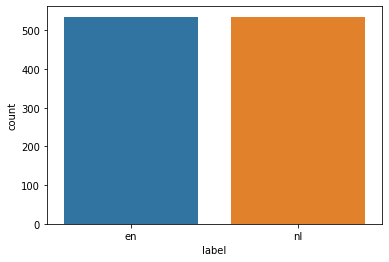

In [30]:
# plotting the distribution of label
# ---
#
sns.countplot(df['label']);

In [31]:
# investigating the label distribution
df['label'].value_counts()

nl    535
en    534
Name: label, dtype: int64

From above, we can see that our dataset is unbalanced thus we will need to sample equal no. of records for each label during data preparation to make a balanced dataset.

## <font color='#2F4F4F'>Step 4. Data Preparation</font>

### <font color='#2F4F4F'>3.1 Data Cleaning</font>

In [32]:
# check for duplicates
df.duplicated().sum()

10

There are 10 duplicates. We will need to drop these.

In [33]:
# check for missing values
df.isna().sum()

text     0
label    0
dtype: int64

No missing values found. 

In [34]:
# dropping our duplicates
df = df.drop_duplicates()
df.shape

(1059, 2)

In [35]:
# What values are in our label variable?
# ---
#
df.label.unique()

array(['en', 'nl'], dtype=object)

In [36]:
# sampling text with en 
df_en = df[df["label"] == 'en'] 
df_en = df_en.sample(200)

# sampling text with nl 
df_nl = df[df["label"] == 'nl'] 
df_nl = df_nl.sample(200)

# combining our dataframes
df = pd.concat([df_en, df_nl])
df.head()

,text,label
556,"In the absence of enzymic catalysis, hydrolysis reactions of simple polyphosphates such as pyrophosphate, linear",en
668,He attended Dallas' Booker T. Washington High School for the Performing and Visual Arts before,en
1020,The band released Reverberation to mostly negative reviews though the album has subsequently garnered some,en
941,In January FanHouse began hiring experienced print journalists including Jay Mariotti of the Chicago SunTimes,en
61,"the in unsuccessfully Communist 1962, University co-founding Thembu the Defiance A for and",en


In [37]:
# investigating the label distribution
df['label'].value_counts()

en    200
nl    200
Name: label, dtype: int64

In [38]:
df.sample(5)

,text,label
885,The fifth digit on the hindlimbs of Dorygnathus was unusually long and oriented to the,en
193,"particularly metals, with for electrical allotrope) silver occur common metal.[7] electrical superfluid any higher VHF",en
771,Lee is een plaats village in de Amerikaanse staat Illinois en valt bestuurlijk gezien onder,nl
244,left upon artisans and north-western own India society nomadic and the north.[104][105] raising vast to,en
978,Keating remained in the Organized Reserve Corps after his wartime service was promoted to brigadier,en


In [39]:
df.shape

(400, 2)

We now have our balanced dataset. 

### <font color='#2F4F4F'> 3.2 Text Cleaning</font>

In [40]:
# We will create a custom function that will contain all the text cleaning 
# techniques. We can then reuse the same function for cleaning new data
# without rewriting the code.

def text_cleaning(text):
  # Removing url/links
  df['text'] = df.text.apply(lambda x: re.sub(r'http\S+|www\S+|https\S+','', str(x)))

  # Removing @ and # characters and replacing them with space
  df['text'] = df.text.str.replace('#',' ')
  df['text'] = df.text.str.replace('@',' ') 

  # Conversion to lowercase 
  df['text'] = df.text.apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Removing punctuation characters
  df['text'] = df.text.str.replace('[^\w\s]','')

  # Removing stop words
  df['text'] = df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # Lemmatization
  df['text'] = df.text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  

In [41]:
# Applying the text_cleaning function to our dataframe.
# ---
# NB: This process may take 5-10 min.


df['text'].apply(text_cleaning)
df.sample(5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.


,text,label
456,1042 tweede barcelona doelpunt meter maakte het eerste thierry een en om een wedstrijd doelpunten,nl
990,five primary school nearest high school beamont collegiate academy,en
702,company luger blixten exiting role blixten managed swedish artist lorentz,en
416,door niet hij het verwijderde recht van op het hij nieuwe scherpe,nl
710,indien men uji dainagon monogatari al een uitgebreide uitgave van de konjaku monogatari beschouwt dan,nl


### <font color='#2F4F4F'> 3.3 Feature Engineering</font>

In [57]:
# We will create a custom function that will contain all the 
# feature engineering techniques. We can then use this function 
# for cleaning new data. 

def feature_engineering(text):
  # Length of tweet
  df['length_of_text'] = df.text.str.len()

  # Word count 
  df['word_count'] = df.text.apply(lambda x: len(str(x).split(" ")))

  # Word density (Average no. of words / tweet)
  df['avg_word_length'] = df.text.apply(lambda x: avg_word(x)) 
  
  # Noun Count
  df['noun_count'] = df.text.apply(lambda x: pos_check(x, 'noun'))

  # Verb Count
  df['verb_count'] = df.text.apply(lambda x: pos_check(x, 'verb'))

  # Adjective Count / Tweet
  df['adj_count'] = df.text.apply(lambda x: pos_check(x, 'adj'))

  # Adverb Count / Tweet
  df['adv_count'] = df.text.apply(lambda x: pos_check(x, 'adv'))

  # Pronoun 
  df['pron_count'] = df.text.apply(lambda x: pos_check(x, 'pron'))

  # Subjectivity 
  df['subjectivity'] = df.text.apply(get_subjectivity)

  # Polarity
  df['polarity'] = df.text.apply(get_polarity)



In [58]:
# Applying the custom feature engineering function to our dataframe.
# This process may take 2-5 min.
# ---
#
df['text'].apply(feature_engineering)
df.sample(5)


,text,label,length_of_text,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,pron_count,subjectivity,polarity
951,byu cougar woman soccer team represented byu ncaa division woman soccer,en,71,11,5.545455,9,1,1,0,0,0.0,0.0
174,presence originated runic among myrvoll used attestation,en,56,7,7.142857,3,2,1,0,0,0.0,0.0
905,tour de france th edition tour de france taking place,en,53,10,4.400000,6,1,0,0,0,0.0,0.0
344,om van tesla vol maat wekken long reusachtige bekend de ten produceerde vervolgens proefinstallatie een,nl,103,15,5.933333,6,2,3,1,0,0.0,0.0
527,zijn alle gouden objecten bruin gekleurd gelijk aan de kleur van de paarden de tot,nl,82,15,4.533333,4,1,2,1,0,0.0,0.0


In [59]:
# Performing further feature engineering techniques
# ---

# Feature Construction: Word Level N-Gram TF-IDF Feature 

tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', ngram_range=(1,3),  stop_words= 'english')
df_word_vect = tfidf.fit_transform(df.text) 



In [60]:
# Feature Construction: Character Level N-Gram TF-IDF 
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char', ngram_range=(1,3),  stop_words= 'english')
df_char_vect = tfidf.fit_transform(df.text)


In [61]:
# Let's prepare the constructed features for modeling
# ---
# We will select all variables but the target (which is the label) and text variables 

X_metadata = np.array(df[df.columns.difference(['text', 'label'])])
X_metadata


array([[ 2.        ,  0.        ,  8.77777778, ...,  0.        ,
         0.        ,  9.        ],
       [ 2.        ,  0.        ,  6.55555556, ...,  0.        ,
         2.        ,  9.        ],
       [ 2.        ,  2.        ,  7.6       , ...,  0.        ,
         2.        , 10.        ],
       ...,
       [ 3.        ,  1.        ,  5.        , ...,  0.        ,
         0.        , 13.        ],
       [ 4.        ,  0.        ,  6.92857143, ...,  0.        ,
         0.        , 14.        ],
       [ 4.        ,  0.        ,  5.73333333, ...,  0.        ,
         0.        , 15.        ]])

In [47]:
# We combine our two tfidf (sparse) matrices and X_metadata

X = scipy.sparse.hstack([df_word_vect, df_char_vect, X_metadata])
X

<400x2010 sparse matrix of type '<class 'numpy.float64'>'
	with 52587 stored elements in COOrdinate format>

In [48]:
# Label Preparation i.e. replacing categorial values with numerical ones


y = np.array(df['label'].replace(['en', 'nl'], ['0','1']))
y

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

##  <font color='#2F4F4F'>Step 5. Data Modeling</font>

We will carry out 10 types of classification analysis, namely:
1.  Logistic Regression
3.  Decision Trees Classification
4.  Support Vector Machine (SVM) Classification
5. K-Nearest Neighbors (KNN) Classification
6.  Gaussian Naive Bayes (NB) Classification
7.  BaggingClassifier
8.  RandomForestClassifier
9.  AdaBoostClassifier
10. GradientBoostingClassifier

We use their default parameters then compare the different classification models to assess the best performing one(s). 

In [63]:
# splitting into 80-20 train-test sets
# ---


#
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [64]:
# loading our classification libraries
# ---
#

from sklearn.linear_model import LogisticRegression      # Logistic Regression Classifier
from sklearn.tree import DecisionTreeClassifier          # Decision Tree Classifier
from sklearn.svm import SVC                              # SVM Classifier
from sklearn.naive_bayes import MultinomialNB            # Naive Bayes Classifier
from sklearn.neighbors import KNeighborsClassifier       # KNN Classifier

# Ensemble classifiers
from sklearn.ensemble import BaggingClassifier           # Bagging Meta-Estimator Classifier
from sklearn.ensemble import RandomForestClassifier      # RandomForest Classifier 
from sklearn.ensemble import AdaBoostClassifier          # AdaBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier  # AdaBoost GradientBoostingClassifier
import xgboost as xgb                                    # Importing the XGBoost library


# instantiating our classifiers
# ---
#
logistic_classifier = LogisticRegression(solver='saga', max_iter=800, multi_class='multinomial') # solver works well with a large dataset like ours
decision_classifier = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier()
naive_classifier = MultinomialNB() 

bagging_meta_classifier = BaggingClassifier()
random_forest_classifier = RandomForestClassifier()
ada_boost_classifier = AdaBoostClassifier(random_state=42)
gbm_classifier = GradientBoostingClassifier(random_state=42) 
xg_boost_classifier = xgb.XGBClassifier() 




In [65]:
# fitting our classifiers to the training data
# ---
logistic_classifier.fit(X_train, y_train)
decision_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)
naive_classifier.fit(X_train, y_train) 

bagging_meta_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)
ada_boost_classifier.fit(X_train, y_train)
gbm_classifier.fit(X_train, y_train)
xg_boost_classifier.fit(X_train, y_train)


# making predictions
# ---
logistic_y_prediction = logistic_classifier.predict(X_test) 
decision_y_prediction = decision_classifier.predict(X_test) 
svm_y_prediction = svm_classifier.predict(X_test) 
knn_y_prediction = knn_classifier.predict(X_test) 
naive_y_prediction = naive_classifier.predict(X_test)  

bagging_y_classifier = bagging_meta_classifier.predict(X_test) 
random_forest_y_classifier = random_forest_classifier.predict(X_test) 
ada_boost_y_classifier = ada_boost_classifier.predict(X_test)
gbm_y_classifier = gbm_classifier.predict(X_test)
xg_boost_y_classifier = xg_boost_classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [66]:
# Evaluating the Models
# ---

# Accuracy scores

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Accuracy scores
#
print("Logistic Regression Classifier", accuracy_score(logistic_y_prediction, y_test))
print("Decision Trees Classifier", accuracy_score(decision_y_prediction, y_test))
print("SVN Classifier", accuracy_score(svm_y_prediction, y_test))
print("KNN Classifier", accuracy_score(knn_y_prediction, y_test))
print("Naive Bayes Classifier", accuracy_score(naive_y_prediction, y_test))
 
print("Bagging Classifier", accuracy_score(bagging_y_classifier, y_test))
print("Random Forest Classifier", accuracy_score(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", accuracy_score(ada_boost_y_classifier, y_test))
print("GBM Classifier", accuracy_score(gbm_y_classifier, y_test))
print("XGBoost Classifier", accuracy_score(xg_boost_y_classifier, y_test))

Logistic Regression Classifier 0.9625
Decision Trees Classifier 0.925
SVN Classifier 0.8875
KNN Classifier 0.9875
Naive Bayes Classifier 0.9375
Bagging Classifier 0.95
Random Forest Classifier 0.975
Ada Boost Classifier 0.9875
GBM Classifier 0.975
XGBoost Classifier 0.975


In [55]:
# Confusion matrices
# ---
# 
print('Logistic Regression Classifier:')
print(confusion_matrix(logistic_y_prediction, y_test))

print('Decision Trees Classifier:')
print(confusion_matrix(decision_y_prediction, y_test))

print('SVN Classifier:')
print(confusion_matrix(svm_y_prediction, y_test))

print('KNN Classifier:')
print(confusion_matrix(knn_y_prediction, y_test))

print('Naive Bayes Classifier:')
print(confusion_matrix(naive_y_prediction, y_test))
 
print('Bagging Classifier:')
print(confusion_matrix(bagging_y_classifier, y_test))

print('Random Forest Classifier:')
print(confusion_matrix(random_forest_y_classifier, y_test))

print('Ada Boost Classifier:')
print(confusion_matrix(ada_boost_y_classifier, y_test))

print('GBM Classifier:')
print(confusion_matrix(gbm_y_classifier, y_test))

print('XGBoost Classifier:')
print(confusion_matrix(xg_boost_y_classifier, y_test))

Logistic Regression Classifier:
[[44  3]
 [ 0 33]]
Decision Trees Classifier:
[[42  4]
 [ 2 32]]
SVN Classifier:
[[39  4]
 [ 5 32]]
KNN Classifier:
[[44  1]
 [ 0 35]]
Naive Bayes Classifier:
[[39  0]
 [ 5 36]]
Bagging Classifier:
[[43  3]
 [ 1 33]]
Random Forest Classifier:
[[44  2]
 [ 0 34]]
Ada Boost Classifier:
[[44  1]
 [ 0 35]]
GBM Classifier:
[[44  2]
 [ 0 34]]
XGBoost Classifier:
[[44  2]
 [ 0 34]]


In [67]:
# Classification Reports
# ---
# 
print("Logistic Regression Classifier", classification_report(logistic_y_prediction, y_test))
print("Decision Trees Classifier", classification_report(decision_y_prediction, y_test))
print("SVM Classifier", classification_report(svm_y_prediction, y_test))
print("KNN Classifier", classification_report(knn_y_prediction, y_test))
print("Naive Bayes Classifier", classification_report(naive_y_prediction, y_test))
 
print("Bagging Classifier", classification_report(bagging_y_classifier, y_test))
print("Random Forest Classifier", classification_report(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", classification_report(ada_boost_y_classifier, y_test))
print("GBM Classifier", classification_report(gbm_y_classifier, y_test))
print("XGBoost Classifier", classification_report(xg_boost_y_classifier, y_test))

Logistic Regression Classifier               precision    recall  f1-score   support

           0       1.00      0.94      0.97        47
           1       0.92      1.00      0.96        33

    accuracy                           0.96        80
   macro avg       0.96      0.97      0.96        80
weighted avg       0.97      0.96      0.96        80

Decision Trees Classifier               precision    recall  f1-score   support

           0       0.95      0.91      0.93        46
           1       0.89      0.94      0.91        34

    accuracy                           0.93        80
   macro avg       0.92      0.93      0.92        80
weighted avg       0.93      0.93      0.93        80

SVM Classifier               precision    recall  f1-score   support

           0       0.89      0.91      0.90        43
           1       0.89      0.86      0.88        37

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
we

Your observation about the performance of the models...



KNN Classifier & Ada Boost Classifier are the best models giving a score of 98.75% each.

## <font color='#2F4F4F'>Step 6. Summary of Findings and Recommendation</font>

Our best performing model was KNN Classifier & Ada Boost Classifier . To improve our model, we can try perfoming other text processing techniques that would better prepare our data for fitting our model. We can also use different vectorizing techniques, implement other machine learning models, perform hyperparameter tuning and sample a balanced dataset.

## <font color='#2F4F4F'>Step 7. Challenging our Solution</font>


We had the right data & question. Our model has an accuracy score of 98.75%, no need for further text processing improvements.

